**Experiment with Descartes Labs API and inventory datasets**

Let's see what datasets are available via the Descartes Labs API.


In [14]:
# Import plotting packages
%matplotlib inline
import matplotlib.pyplot as plt
import shapely.geometry
# import cartopy

# Import Descartes Labs library 
# import descarteslabs as dl
# from pprint import pprint

In [ ]:
sources = dl.metadata.sources()
pprint (sources)

In [ ]:
# Find potential matches
matches = dl.places.find('honduras')
pprint(matches)
# The first one looks good to me, so lets make that our area of interest.
aoi = matches[0]

In [ ]:
aoi = matches[0]
shape = dl.places.shape(aoi['slug'], geom='low')
bbox = shape['bbox']

# Lets load up the Albers Equal Area projection.
lonlat_crs = cartopy.crs.PlateCarree()
albers = cartopy.crs.AlbersEqualArea(central_latitude=36.0, central_longitude=-105)

fig = plt.figure(figsize=(4, 8))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])

# When adding a geometry in latlon coordinates, specify the latlon projection
ax.add_geometries([shp], lonlat_crs)

# You can set extents in latlon, as long as you specify the projection with `crs`
ax.set_extent((bbox[0], bbox[2], bbox[1], bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

In [ ]:
import json
feature_collection = dl.metadata.search(products='landsat:LC08:PRE:TOAR', start_time='2017-03-12',
                                        end_time='2015-03-20', limit=10, place=aoi['slug'])

print len(feature_collection['features'])

In [ ]:
arr, meta = dl.raster.ndarray(
    f0['id'],
    bands=['red', 'green', 'blue', 'alpha'],
    scales=[[0,4000], [0, 4000], [0, 4000], None],
    data_type='Byte',
    resolution=30,
    cutline=shape['geometry'],
)


In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(arr)

**Test technique for classification of Landsat imagery**

Using scikit-learn learn and gdal, we can create training data to classify urban areas in imagery. I am following along with this tutorial: https://www.machinalis.com/blog/python-for-geospatial-data-processing/


In [3]:
import numpy as np
import os

from osgeo import gdal
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

Test data includes a preprocessed Landsat image, shapefile training data broken into five classes, and data to test results.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
from osgeo import gdal
print (gdal.OpenEx)

<built-in function OpenEx>


In [6]:
# A list of "random" colors (for a nicer output)
COLORS = ["#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941"]

Here, I define functions to aid in rasterizing important vector datasets. 

In [7]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds

def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    from osgeo import gdal
    gdal.UseExceptions()
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels


def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

Next, we have to define our datasets, including train, test, and imagery:

In [8]:
raster_data_path = "data/image/2298119ene2016recorteTT.tif"
output_fname = "classification.tiff"
train_data_path = "data/test/"
validation_data_path = "data/train/"

Next, we let's stuff all our pixel values into a stack of numpy arrrays for analysis:

In [9]:
raster_dataset = gdal.Open(raster_data_path, gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
bands_data = []
for b in range(1, raster_dataset.RasterCount+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape

We also have to rasterize our vector datasets using the previously defined functions:

In [10]:
files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]
classes = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(train_data_path, f)
              for f in files if f.endswith('.shp')]

labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform,
                                   proj)
is_train = np.nonzero(labeled_pixels)
training_labels = labeled_pixels[is_train]
training_samples = bands_data[is_train]


`training_samples` is the list of pixels to be used for training. In our case, a pixel is a point in the 7-dimensional space of the bands.

`training_labels` is a list of class labels such that the i-th position indicates the class for i-th pixel in `training_samples`.

#### Train the classifier model

So now, we know what pixels of the input image must be used for training. Next, we instantiate a RandomForestClassifier from Scikit-learn.

In [16]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(training_samples, training_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Apply the model to our data
Let's use our random forest classifier to predict which class our data's pixels belongs to.

In [18]:
n_samples = rows*cols
flat_pixels = bands_data.reshape((n_samples, n_bands))
result = classifier.predict(flat_pixels)
classification = result.reshape((rows, cols))

We used the trained object to classify all the input image. Our classifier knows how to train pixels and its `predict` function expects a list of pixels, not an NxM matrix. Because of that, we reshaped the bands data before and after the classification (so that the output looks like an image and not just a list of multi-dimensional pixels).

At this point, if you have `matplotlib` installed you can visualize the results:

/Users/karla/anaconda3/envs/poverty-predictor/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


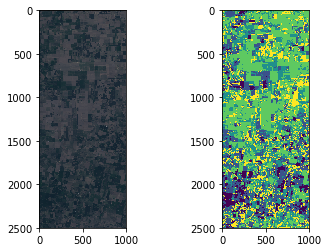

In [21]:
from matplotlib import pyplot as plt
f = plt.figure()
f.add_subplot(1, 2, 2)
r = bands_data[:,:,3]
g = bands_data[:,:,2]
b = bands_data[:,:,1]
rgb = np.dstack([r,g,b])
f.add_subplot(1, 2, 1)
plt.imshow(rgb/255)
f.add_subplot(1, 2, 2)
plt.imshow(classification)
